# Visualizing Word2Vec Word Embeddings using t-SNE

### Import

In [337]:
import gensim
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import warnings
import re
import codecs
import multiprocessing
import gensim
import nltk
import ssl
from tqdm import tqdm
from sklearn.manifold import TSNE
from matplotlib import font_manager as fm, rcParams
from gensim.models import Word2Vec

### SSL

In [338]:
ssl._create_default_https_context = ssl._create_unverified_context

### TSNE Plot Helper Function

In [257]:
def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, count, filename="test"):
    plt.figure(figsize=(6,6))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, color=color, alpha=a, label=label)
        for i, word in enumerate([words[count]]):
            plt.annotate(word, alpha=1.0, xy=(x[i]+1, y[i]), 
                         xytext=(5, 2),
                         textcoords='offset points', 
                         ha='right', va='bottom', **csfont, size=8, weight='bold')
    L = plt.legend(loc='center left', bbox_to_anchor=(1, 0.2),frameon=False)
    plt.setp(L.texts, family='Georgia')
    plt.title(title,**csfont,fontsize=16)
    plt.tick_params(left = False)
    plt.tick_params(bottom = False)
    plt.xticks([])
    plt.yticks([])
    plt.savefig(filename, format='png', dpi=300, bbox_inches='tight')
    plt.show()

### Fonts

In [194]:
csfont = {'fontname':'Georgia'}
hfont = {'fontname':'Helvetica'}

### Load the GoogleNews Word2Vec Model

In [195]:
filename = '../../data/google/GoogleNews-vectors-negative300.bin'
model = gensim.models.KeyedVectors.load_word2vec_format(filename, binary=True)

### Lets define a few key words and look at the similar words

In [261]:
keys = ['civilization','cancer','videogames','psychology','medicine','philosophy','financial']
embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = [word]
    for similar_word, _ in model.most_similar(word, topn=29):
        embeddings.append(model[similar_word])
        similar_word = similar_word.replace('_',' ')
        similar_word = similar_word.lower()
        words.append(similar_word)
    embedding_clusters.append(embeddings)
    word_clusters.append(words)
embedding_clusters = np.array(embedding_clusters)

### Do tSNE on them to get a 2D latent space

In [263]:
warnings.filterwarnings("ignore")
n, m, k = embedding_clusters.shape
count = 30
for i in range(count):
    tsne_model_en_2d = TSNE(learning_rate="auto",perplexity=15, n_components=2, init='pca', 
                            n_iter=4000, random_state=32)
    embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)
    tsne_plot_similar_words('Similar words from Google News Word2Vec Model', 
                        keys, 
                        embeddings_en_2d, 
                        word_clusters,
                        0.7, i, str(int(i)) + '.png')

# Finding word relationships

### Draw Arrow Helper Function

In [290]:
def draw_arrow(plt,x,y,dx,dy,text,linestyle,color):
    
    plt.arrow(x, y, dx,dy,
              color=color,
              width = width,
              length_includes_head = True,
              head_width = head_width,
              linestyle = linestyle,
              head_length = head_length)
    plt.text(x+dx+0.1,y+dy+0.1,text,**csfont,fontsize=16)

### Hypothetical Situation

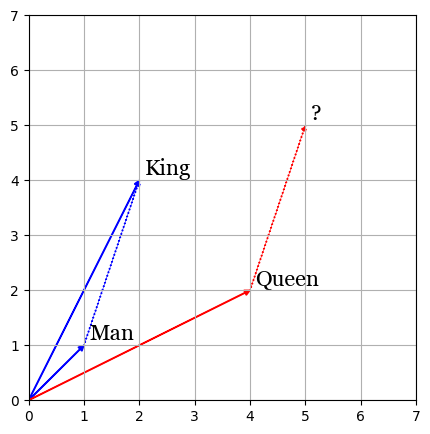

In [295]:
width = 0.01
head_width = 0.1
head_length = 0.1
vec_man = np.array([1,1])
vec_woman = np.array([4,2])
vec_king = np.array([2,4])
vec_man_to_king = vec_king - vec_man

plt.figure(figsize=(5,5))
draw_arrow(plt,0, 0, vec_man[0], vec_man[1],'Man','-','b')
draw_arrow(plt,0, 0, vec_king[0], vec_king[1],'King','-','b')
draw_arrow(plt,vec_man[0], vec_man[1], vec_man_to_king[0], vec_man_to_king[1],'',':','b')
draw_arrow(plt,0, 0, vec_woman[0], vec_woman[1],'Queen','-','r')
draw_arrow(plt,vec_woman[0], vec_woman[1], vec_man_to_king[0], vec_man_to_king[1],'?',':','r')
plt.axis((0,7,0,7))
plt.grid()

### Find Vectors for Man, King and Queen

In [311]:
vec_man = model['man']
vec_king = model['king']
vec_woman = model['woman']
vec_man_to_king = vec_king - vec_man
vec_woman_to_unknown = vec_woman + vec_man_to_king
print(vec_man.shape)
print(vec_king.shape)
print(vec_woman.shape)
print(vec_man_to_king.shape)
print(vec_woman_to_unknown.shape)

(300,)
(300,)
(300,)
(300,)
(300,)


### Use Transformation
Find the words closest to the point given by the transformation of queen to unknown based on the transformation of man to king

In [329]:
results1 = model.most_similar(positive=['woman', 'king'], negative=['man'],topn=10)
results2 = model.most_similar(positive=['hate', 'desire'], negative=['love'],topn=10)
results3 = model.most_similar(positive=['physics', 'evolution'], negative=['biology'],topn=10)
print(results)

[('Einstein_relativity', 0.4816519320011139), ('relativity_theory', 0.4814132750034332), ('Newtonian_physics', 0.47875410318374634), ('quantum_mechanics', 0.47405898571014404), ('quantum_physics', 0.471221923828125), ('universe', 0.46722352504730225), ('Einstein_theories', 0.46264639496803284), ('spacetime', 0.4532492756843567), ('gravitation', 0.4449438154697418), ('Einsteinian', 0.4423460066318512)]


### Gensim Word2Vec Helper Functions

In [342]:
def preprocess_text(text):
    text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)
    text = re.sub(' +', ' ', text)
    return text.strip()

def prepare_for_w2v(filename_from, filename_to, lang):
    raw_text = codecs.open(filename_from, "r").read()
    with open(filename_to, 'w', encoding='utf-8') as f:
        for sentence in nltk.sent_tokenize(raw_text, lang):
            print(preprocess_text(sentence.lower()), file=f)
            
def train_word2vec(filename):
    data = gensim.models.word2vec.LineSentence(filename)
    return Word2Vec(data, vector_size=200, window=5, min_count=3, workers=multiprocessing.cpu_count())

### Use a specific corpus  to train a word2vec using Gensim

In [345]:
#nltk.download('punkt')
prepare_for_w2v('../../data/books/frankenstein.txt', 'train_frankenstein.txt', 'english')
model_frankenstein = train_word2vec('train_frankenstein.txt')

### Get all the word embeddings

In [370]:
words_frankenstein = []
embeddings_frankenstein = []
vocab_frankenstein = model_frankenstein.wv.key_to_index.keys()
for word in list(vocab_frankenstein):
    embeddings_frankenstein.append(model_frankenstein.wv[word])
embeddings_frankenstein = np.array(embeddings_frankenstein)
tsne_frankenstein_2d = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_frankenstein_2d = tsne_frankenstein_2d.fit_transform(embeddings_frankenstein)

### Plot

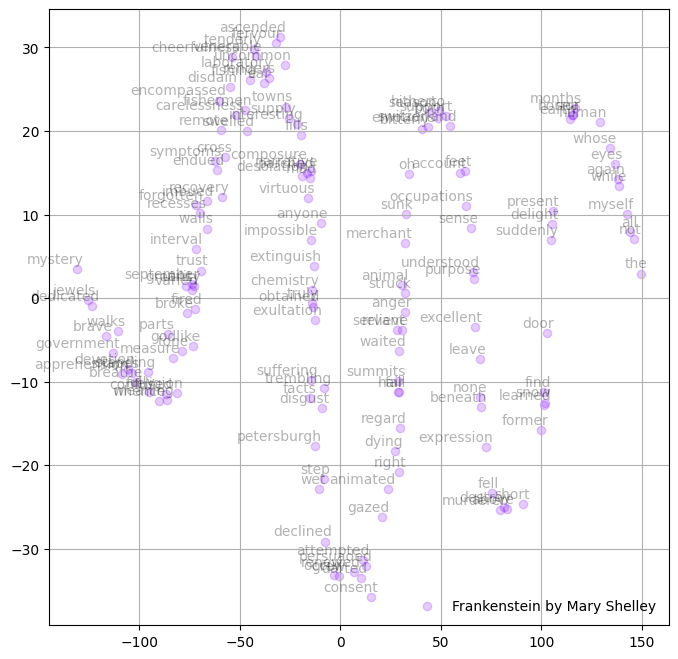

In [374]:
def tsne_plot_2d(label, embeddings, words=[], a=1):
    plt.figure(figsize=(8, 8))
    colors = cm.rainbow(np.linspace(0, 1, 1))
    x = embeddings[:,0]
    y = embeddings[:,1]
    plt.scatter(x, y, c=colors, alpha=a, label=label)
    for i, word in enumerate(words):
        plt.annotate(word, alpha=0.3, xy=(x[i], y[i]), 
                     xytext=(5, 2), 
                     textcoords='offset points',
                     ha='right', va='bottom', size=10)
    plt.legend(loc=4,frameon=False)
    plt.grid(True)
    plt.savefig("hhh.png", format='png', dpi=150, bbox_inches='tight')
    plt.show()
vocab_frankenstein = np.array(list(vocab_frankenstein))
tsne_plot_2d('Frankenstein by Mary Shelley', embeddings_frankenstein_2d[::20], vocab_frankenstein[::20], 0.2)